In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"


import tensorflow as tf
tf.random.set_seed(1234)

import keras
from keras import layers

import os
import glob
import imageio.v2 as imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 1
NUM_SAMPLES = 32
POS_ENCODE_DIMS=16
EPOCHS = 20

2025-03-10 23:06:28.847665: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 23:06:29.007772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741628189.078555    4983 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741628189.097589    4983 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 23:06:29.248607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
url = (
    "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz"
)

data = keras.utils.get_file(origin=url)

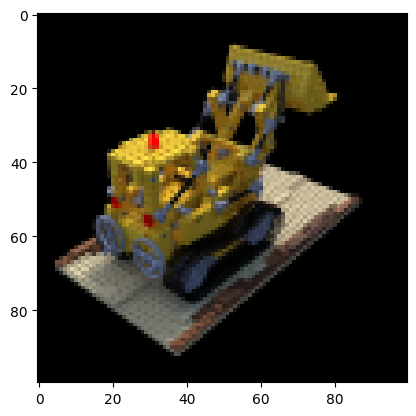

In [4]:
data = np.load(data)
images = data["images"]
im_shape = images.shape
(num_images, H, W,_) = images.shape
(poses, focal) = (data["poses"], data["focal"])

plt.imshow(images[np.random.randint(low=0, high=num_images)])
plt.show()

# 1. Positional Encoding Function

- Encodes positions using Fourier features (`sin` and `cos` functions).
- This helps the network capture high-frequency details in the scene.
- **POS_ENCODE_DIMS** determines how many frequency bands to use.
- NeRFs struggle to model fine details with just MLPs. This encoding helps the model distinguish small changes in position.

# 2. Generating Camera Rays

## **The `get_rays` Function:**
- Creates a grid of pixels in the image plane.
- Converts them into ray directions in camera space.
- Transforms rays into world coordinates using the camera pose.

### **Steps:**

### **1. Create a Meshgrid (Grid of Pixel Coordinates)**
- In computer graphics and NeRF, every pixel in the image corresponds to a ray that originates from the camera.
- We need to know where each pixel is in relation to the camera’s coordinate system.
- The meshgrid creates a structured array of pixel coordinates, so we can systematically generate rays for every pixel.
- We use `meshgrid` because it systematically assigns a unique 3D ray to each pixel, allowing us to render the scene correctly. Without it, we wouldn’t know where to shoot the rays.

### **2. Normalize Pixel Coordinates**
- The origin `(0,0)` is now at the image center.
- The focal length scales the values based on the camera's focal length.

### **3. Create 3D Ray Directions**
- Forms a unit direction vector `[x, y, -1]` for each pixel.
- `-1` means all rays point into the scene along the negative **z-axis**.

### **4. Transform Rays into World Coordinates**
- The pose matrix is a **4×4 transformation matrix**.
  - **R (3×3)** = Camera rotation.
  - **t (3×1)** = Camera position in world coordinates.
- Applies the rotation transformation to get ray directions in world space.

### **5. Compute Ray Origins**
- The camera position is the same for all rays, so we broadcast it.

### **Returns:**
- `ray_origins` = The starting point of rays in world space.
- `ray_directions` = The direction of rays in world space.

---

# 3. Sampling Along the Rays

## **The `render_flat_rays` Function:**
- Samples **num_samples** points along the rays.
- Outputs a flattened tensor of 3D sample points.

### **Steps:**

### **1. Compute Sampled Distances**
- Generates `num_samples` equally spaced values between `near` and `far`.
- Adds random noise to `t_vals` for continuous sampling.

### **2. Compute Sampled 3D Points**
- Computes the 3D points using the ray equation:
  
  \[
  r(t) = o + td
  \]
  
  - **r** = Ray.
  - **o** = Origin.
  - **t** = Distance.
  - **d** = Direction.

- Flattens the points into `rays_flat` for neural network input.
- Applies Fourier encoding to `rays_flat`.

---

# 4. Mapping Function

- Processes a single camera pose.
- Calls **`get_rays`** to generate rays.
- Calls **`render_flat_rays`** to sample points along the rays.

---

# 5. Conclusion

### **1. `get_rays()`**
- Generates camera rays (origins + directions).
- Uses the camera pose to transform them into world coordinates.

### **2. `render_flat_rays()`**
- Samples 3D points along the rays.
- Uses Fourier encoding for better learning.

### **3. `map_fn()`**
- Calls both functions to process a single camera pose.


In [5]:
# encodes the position into it's corresponding Fourier feature

def encode_position(x):
    
    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0 ** i * x))
            
    return tf.concat(positions, axis=-1) # used to combine multiple tensors along the last dimension keeping the batch structure intact


def get_rays(height, width, focal, pose):
    
    # build a meshgrid for the rays
    i,j = tf.meshgrid(tf.range(width, dtype=tf.float32), tf.range(height, dtype=tf.float32), indexing='xy')

    # These lines normalize the pixel coordinates so that the origin is at the center of the image.
    # normalize the x axis coordinates
    transformed_i = (i - width * 0.5) / focal

    # normalize the y axix coordinates
    transformed_j = (j - height * 0.5) / focal

    #create the direction unit vectors
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    # get the camera matrix
    camera_matrix = pose[:3, :3] # Extracts rotation matrix (3×3)
    height_width_focal = pose[:3, -1] # Extracts camera position (translation)

    #get origins and directions for the rays
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix

    # direction unit vectors of the rays
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)

    # the origin points of the rays
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions)) #This ensures that all rays originate from the same camera position (since all rays originate from the camera center)

    return (ray_origins, ray_directions)
    

def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    """
    Renders the rays and flattens it

    Args:
         ray_origins (tf.Tensor): The origin points of the rays
         ray_directions (tf.Tensor): The direction unit vectors of the rays
         near: The near bound of the volumetric scene
         far: The far bound of the volumetric scene
         num_samples: The number of samples to take along each ray
         rand: Whether to sample the rays randomly or not

    Returns:
        A flattened tensor of shape (num_rays, num_samples, 3) containing the sampled points on each ray

    """

    # compute 3d query points
    # equation: r(t) = o + td -> building the 't' here

    t_vals = tf.linspace(near, far, num_samples)
    if rand:
        # inject uniform noise into the sample space to make the sampling continuos 
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
        t_vals = t_vals + noise

    rays = ray_origins[..., None, :] + (ray_directions[..., None, :] * t_vals[..., None])
    rays_flat = tf.reshape(rays, [-1, 3])
    rays_flat = encode_position(rays_flat)
    return (rays_flat, t_vals)
    

def map_fn(pose):
    """Maps individual pose to flattened rays and sample points

        Args:
            pose: The pose matrix of the camera

        Returns:
            Tuple of flattened rays and sample points corresponding to the camera pose
        
    """

    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(ray_origins=ray_origins, ray_directions=ray_directions,near=2.0, far=6.0, num_samples=NUM_SAMPLES, rand=True)
    return (rays_flat, t_vals)

    

## Training and Validation pipeline 

In [6]:
# create training split

split_index = int(num_images * 0.8)

# split images into training and validation
train_images = images[:split_index]
val_images = images[split_index:]

# split the poses into training and validation
train_poses = poses[:split_index]  
val_poses = poses[split_index:]

# make the training pipeline
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)  # converts into tensorflow dataset
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds)) # Combines train_img_ds (images) and train_ray_ds (rays) into a single dataset. 
train_ds = (
    training_ds.shuffle(BATCH_SIZE) # shuffle to improve randomness
    .batch(BATCH_SIZE,drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO) # Uses asynchronous prefetching to load data while the model is training.
)

# make the validation pipeline
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO) # applies map_fn() to each pose in train_pose_ds
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds)) # AUTO parallelizes execution for efficiency
val_ds = (
    validation_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(AUTO)
)


I0000 00:00:1741628192.827472    4983 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5138 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:64:00.0, compute capability: 8.9


## NeRF model

## **Key Idea**
- The model learns how **dense** a point in space is (**σ, sigma**) and what **color** it should be (**c, RGB**).  
- **Density (σ)** determines whether a point is solid (like a surface) or transparent (like air).  
- **Color (c, RGB)** depends on both the point’s position **and** the direction from which it's viewed.  

---

## **How the Model Works**

### **1. Processing Position (x)**
- The model starts by taking a **3D coordinate (x, y, z)** as input.  
- It passes this through **8 fully connected layers** (like deep layers in a neural network), each with **256 neurons**.  
- These layers use **ReLU activation** to introduce non-linearity, helping the network learn complex patterns.  
- After these 8 layers, the network outputs:  
  - **σ (density)** → how solid or transparent the point is.  
  - **A feature vector (size: 256)** → a compressed representation of the scene at that point.  

### **2. Processing Viewing Direction**
- The feature vector is combined with the **camera's viewing direction** (which way you're looking at the scene).  
- This new combined input goes through **one more fully connected layer** with **128 neurons**.  
- This final layer outputs the **RGB color (c)** for that point, taking the viewpoint into account.  

---

## **Why Do This?**
- **Density (σ) depends only on the position (x, y, z)** because an object’s shape doesn’t change based on the viewpoint.  
- **Color (c) depends on both position & viewing direction** because things like reflections and shading change when viewed from different angles.  

---

## **In Simple Terms**
1. First, the network figures out **how solid** a point is.  
2. Then, it adds information about **where you're looking from** to determine the **color of that point**.  
3. This ensures that the 3D scene looks correct from multiple angles (**multi-view consistency**).  


---


In [7]:

def get_nerf_model(num_layers, num_pos):
    """Generates the NeRF neural network.

    Args:
        num_layers: The number of MLP layers.
        num_pos: The number of dimensions of positional encoding.

    Returns:
        The `keras` model.
    """
    inputs = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))
    x = inputs
    for i in range(num_layers):
        x = layers.Dense(units=256, activation="relu")(x)
        if i % 4 == 0 and i > 0:
            # Inject residual connection.
            x = layers.concatenate([x, inputs], axis=-1)
    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)


def render_rgb_depth(model, rays_flat, t_vals, rand=True, train=True):
    """Generates the RGB image and depth map from model prediction.

    Args:
        model: The MLP model that is trained to predict the rgb and
            volume density of the volumetric scene.
        rays_flat: The flattened rays that serve as the input to
            the NeRF model.
        t_vals: The sample points for the rays.
        rand: Choice to randomise the sampling strategy.
        train: Whether the model is in the training or testing phase.

    Returns:
        Tuple of rgb image and depth map.
    """
    # Get the predictions from the nerf model and reshape it.
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4))

    # Slice the predictions into rgb and sigma.
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    # Get the distance of adjacent intervals.
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    # delta shape = (num_samples)
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    # Get transmittance.
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return (rgb, depth_map)


## Training

Epoch 1/20


I0000 00:00:1741628197.278073    5365 service.cc:148] XLA service 0x7ca508022030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741628197.278353    5365 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-03-10 23:06:37.428726: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1741628197.510100    5365 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1741628197.510149    5365 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
I0000 00:00:1741628197.599470    5365 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-03-10 23:06:38.547219: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18', 16 bytes spill stores, 16 bytes sp

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0709 - psnr: 12.0197

W0000 00:00:1741628221.919503    5365 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1741628221.919590    5365 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
2025-03-10 23:07:04.366477: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 8 bytes spill stores, 8 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step


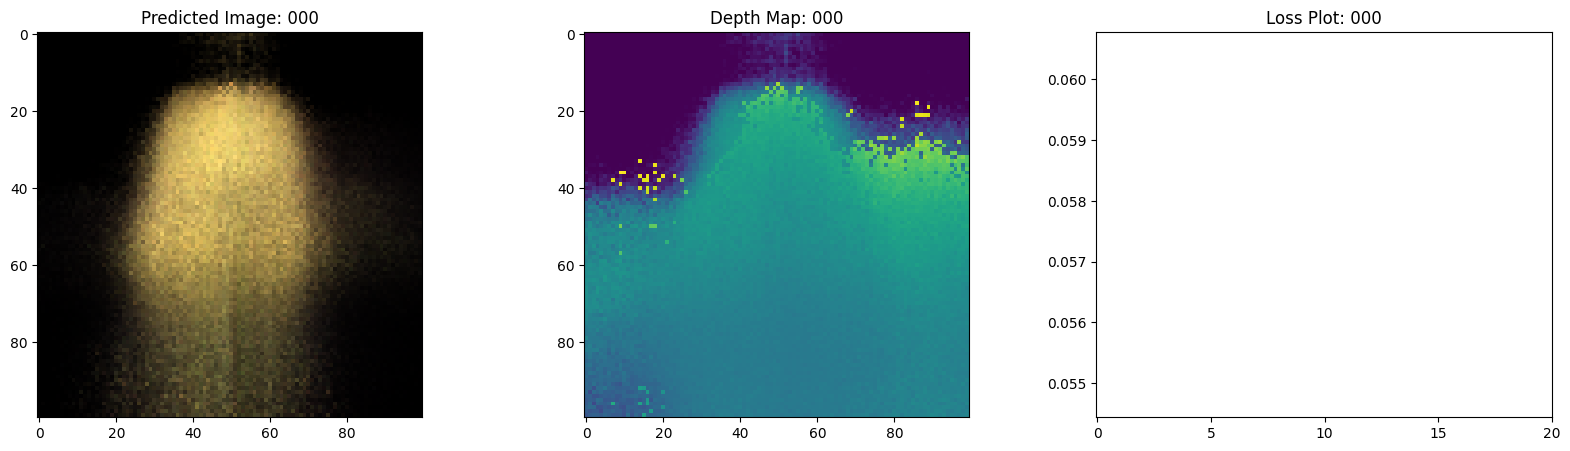

84/84 ━━━━━━━━━━━━━━━━━━━━ 30s 265ms/step - loss: 0.0707 - psnr: 12.0301 - val_loss: 0.0341 - val_psnr: 14.8875
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/stepep - loss: 0.0293 - psnr: 15.566


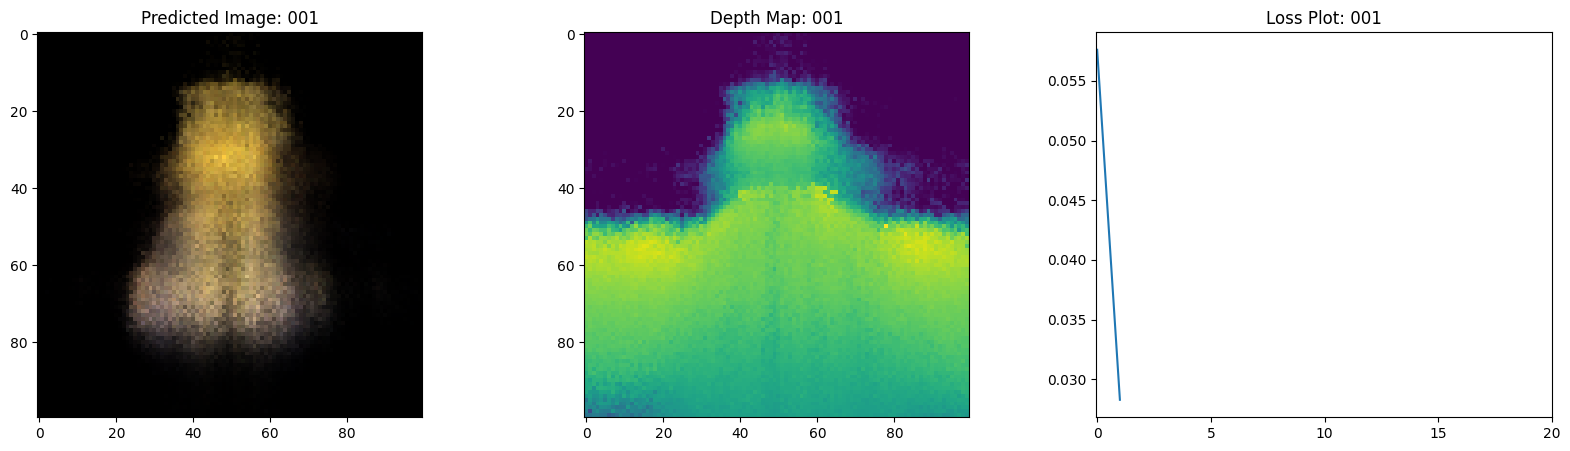

84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - loss: 0.0292 - psnr: 15.5689 - val_loss: 0.0224 - val_psnr: 16.7064
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/steptep - loss: 0.0191 - psnr: 17.415


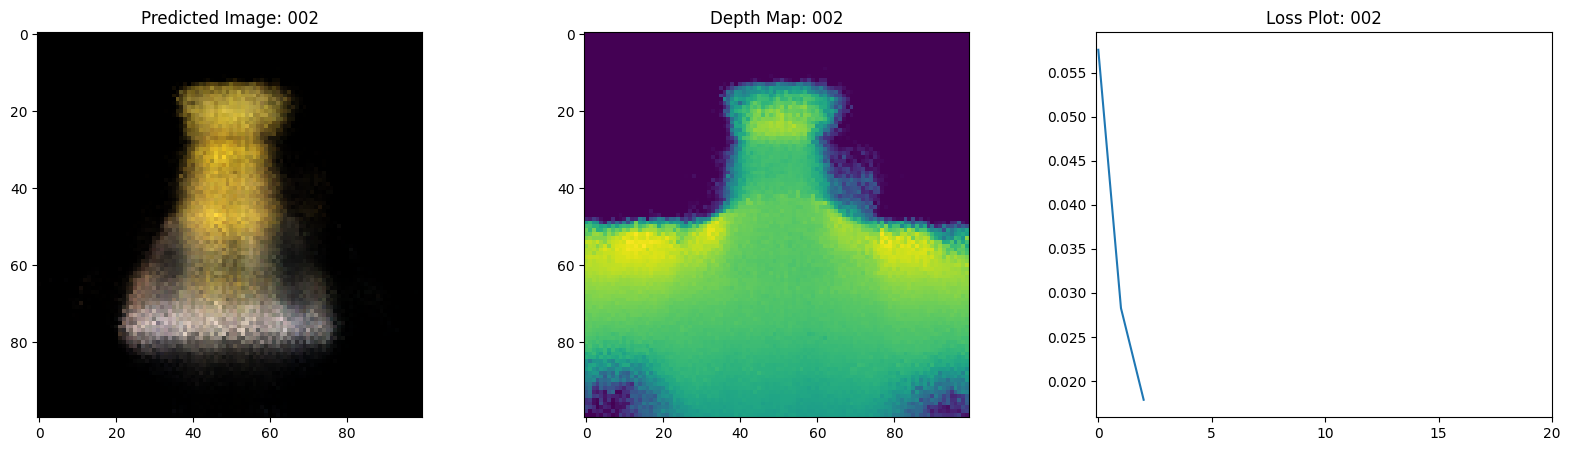

84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - loss: 0.0190 - psnr: 17.4182 - val_loss: 0.0154 - val_psnr: 18.2549
Epoch 4/20


2025-03-10 23:07:45.844396: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 128120000 bytes after encountering the first element of size 128120000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/stepep - loss: 0.0143 - psnr: 18.641


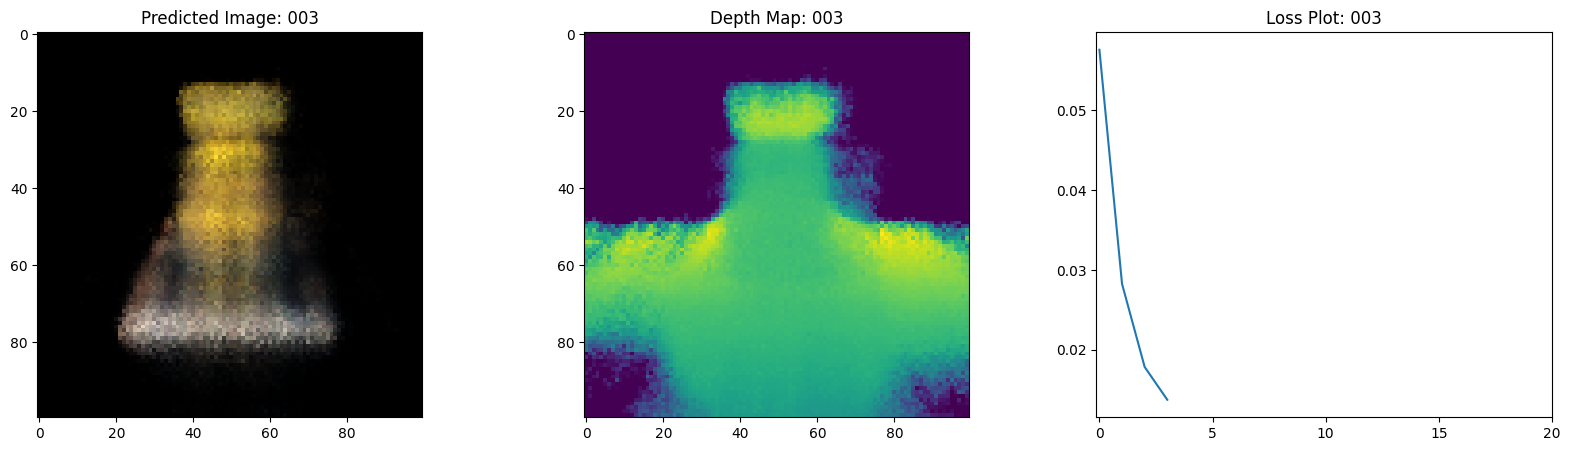

84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - loss: 0.0143 - psnr: 18.6433 - val_loss: 0.0124 - val_psnr: 19.2092
Epoch 5/20


2025-03-10 23:08:05.957985: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 128120000 bytes after encountering the first element of size 128120000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/stepep - loss: 0.0120 - psnr: 19.430


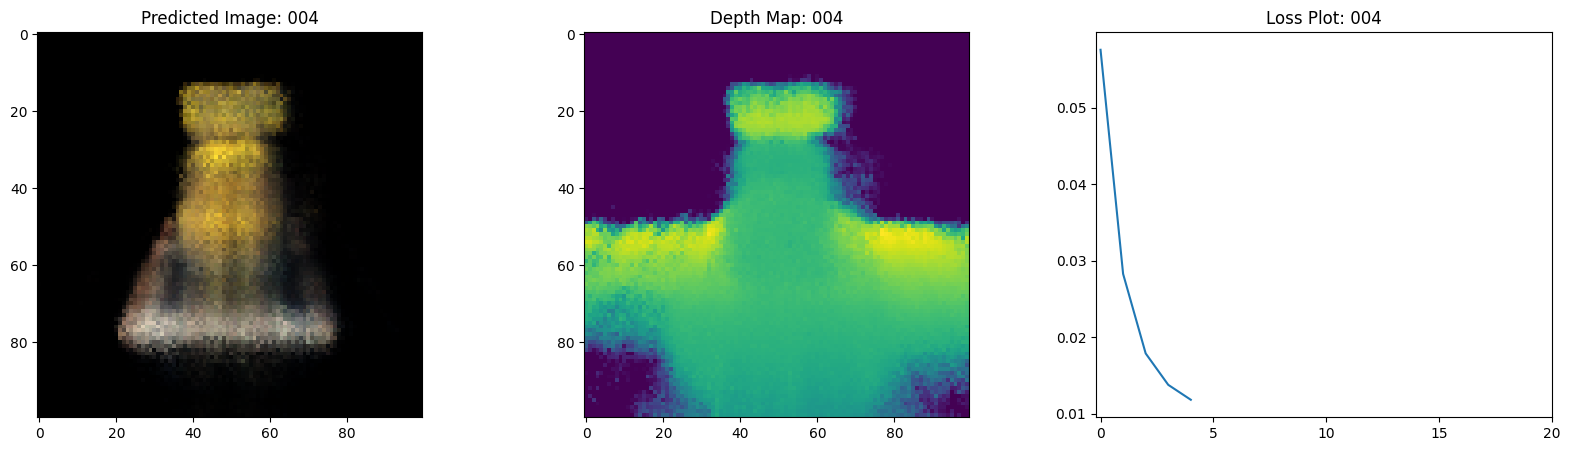

84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - loss: 0.0120 - psnr: 19.4307 - val_loss: 0.0109 - val_psnr: 19.7644
Epoch 6/20


2025-03-10 23:08:26.083716: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 128120000 bytes after encountering the first element of size 128120000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/stepep - loss: 0.0107 - psnr: 19.894


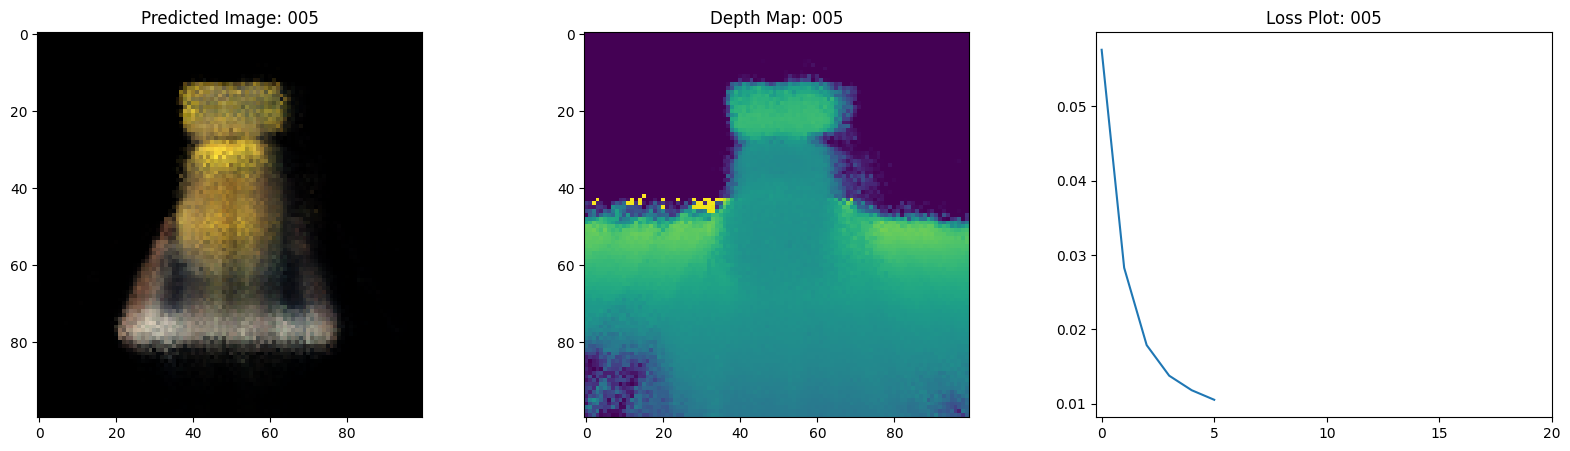

84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - loss: 0.0107 - psnr: 19.8951 - val_loss: 0.0097 - val_psnr: 20.2888
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/stepep - loss: 0.0096 - psnr: 20.354


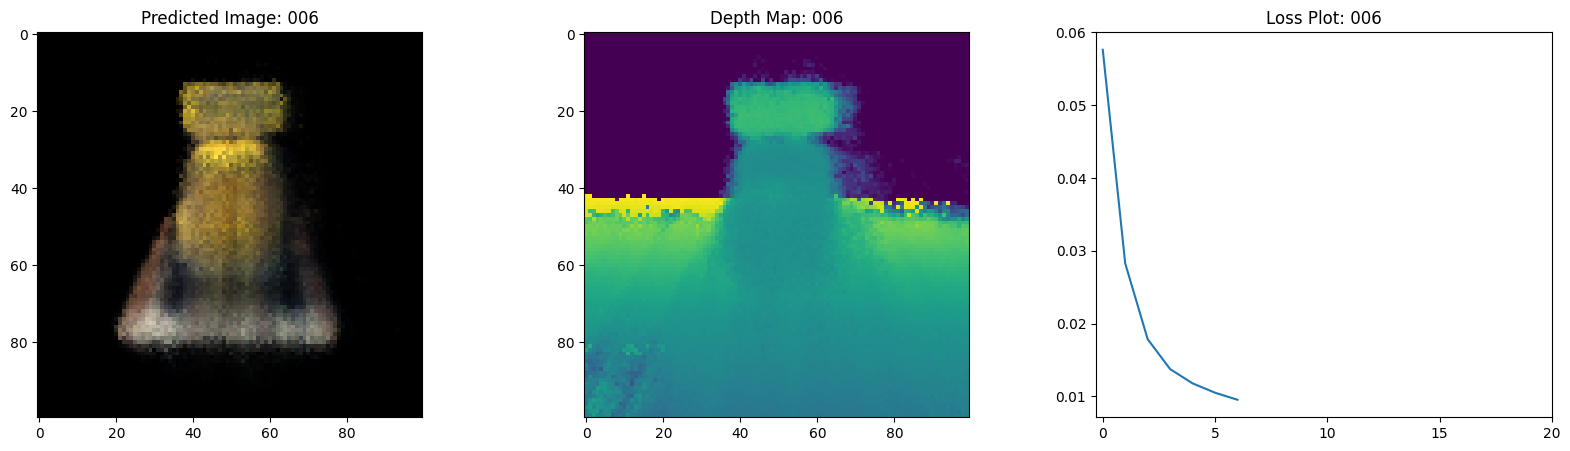

84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - loss: 0.0096 - psnr: 20.3547 - val_loss: 0.0092 - val_psnr: 20.5258
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/stepep - loss: 0.0090 - psnr: 20.632


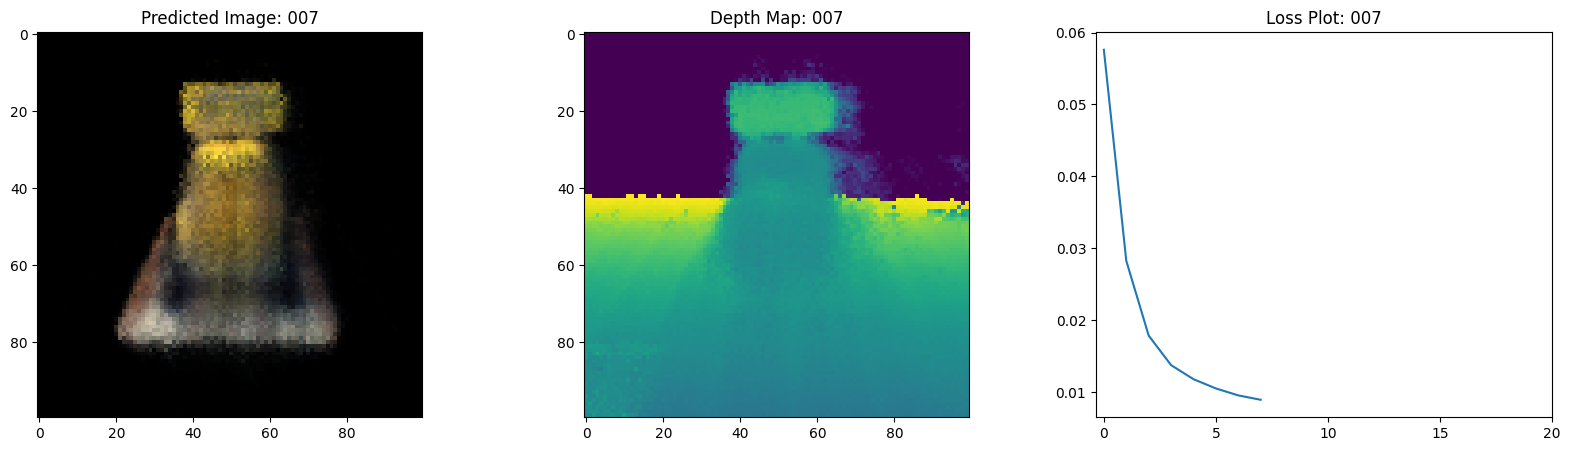

84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - loss: 0.0090 - psnr: 20.6323 - val_loss: 0.0087 - val_psnr: 20.7458
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/stepep - loss: 0.0087 - psnr: 20.799


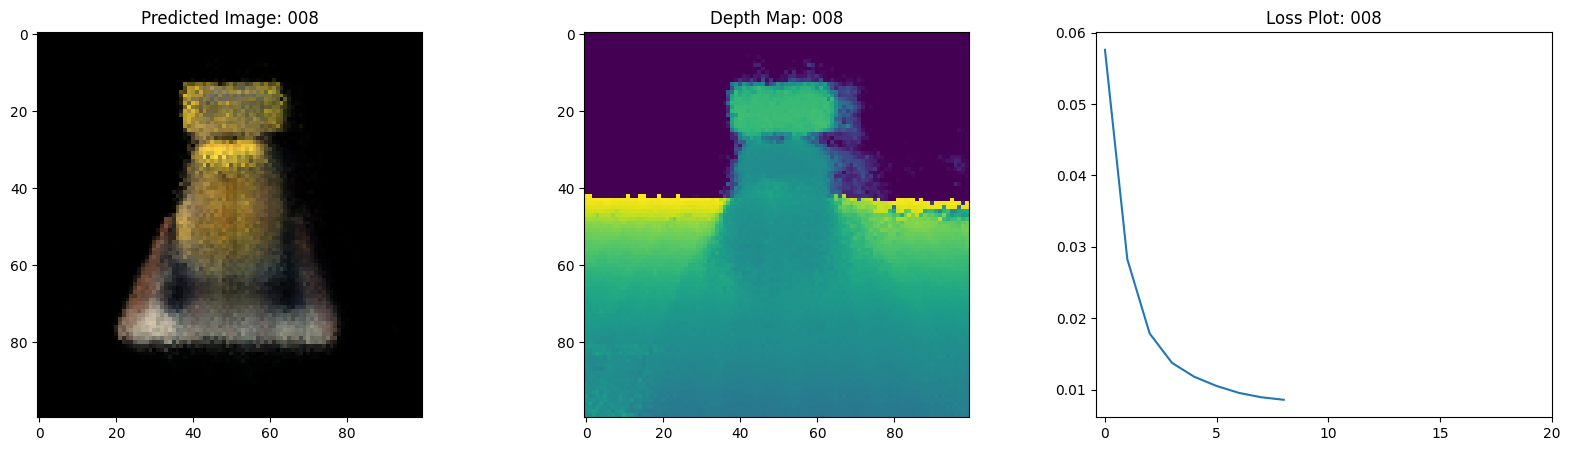

84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - loss: 0.0087 - psnr: 20.7994 - val_loss: 0.0084 - val_psnr: 20.9043
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/stepep - loss: 0.0083 - psnr: 20.987


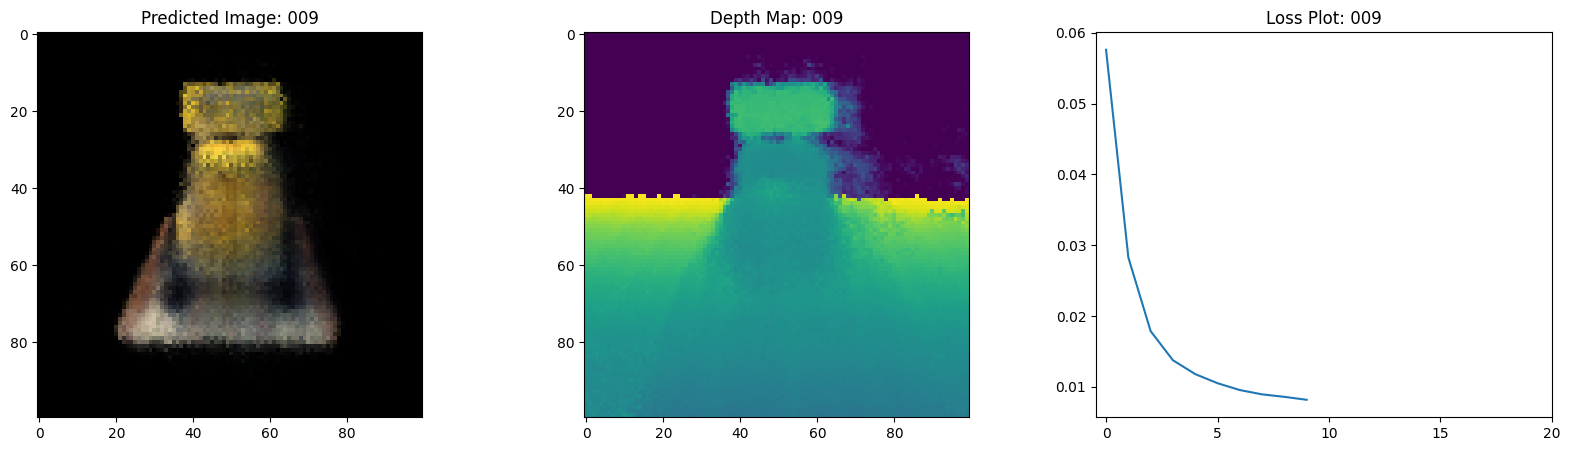

84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - loss: 0.0083 - psnr: 20.9877 - val_loss: 0.0082 - val_psnr: 21.0288
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/steptep - loss: 0.0080 - psnr: 21.152


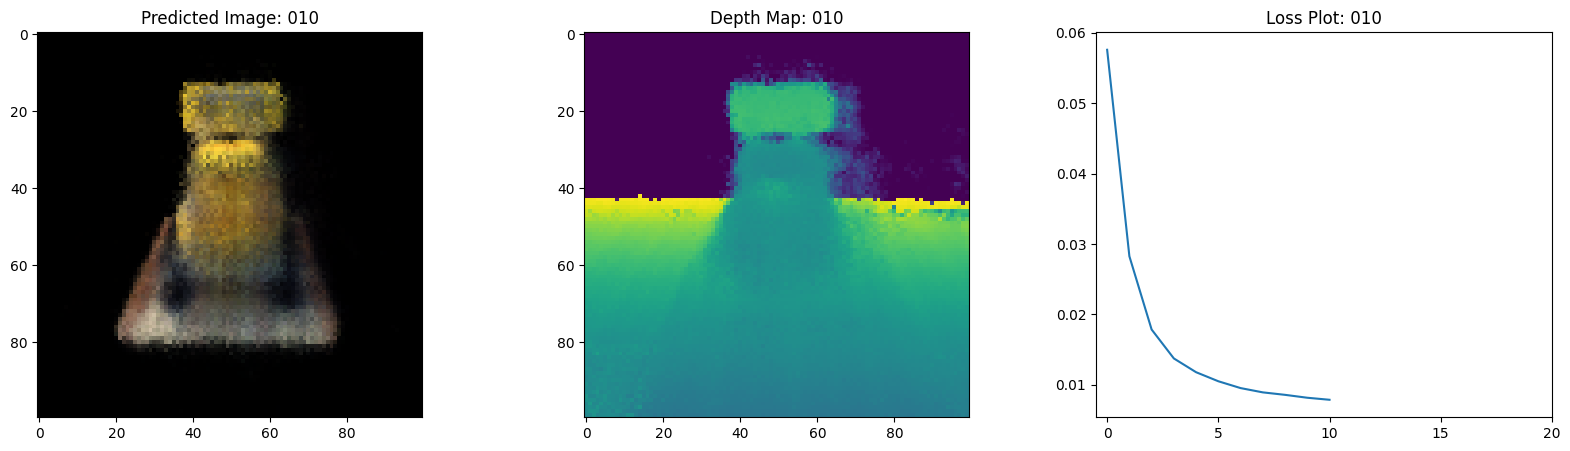

84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - loss: 0.0080 - psnr: 21.1528 - val_loss: 0.0080 - val_psnr: 21.1259
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/stepep - loss: 0.0077 - psnr: 21.314


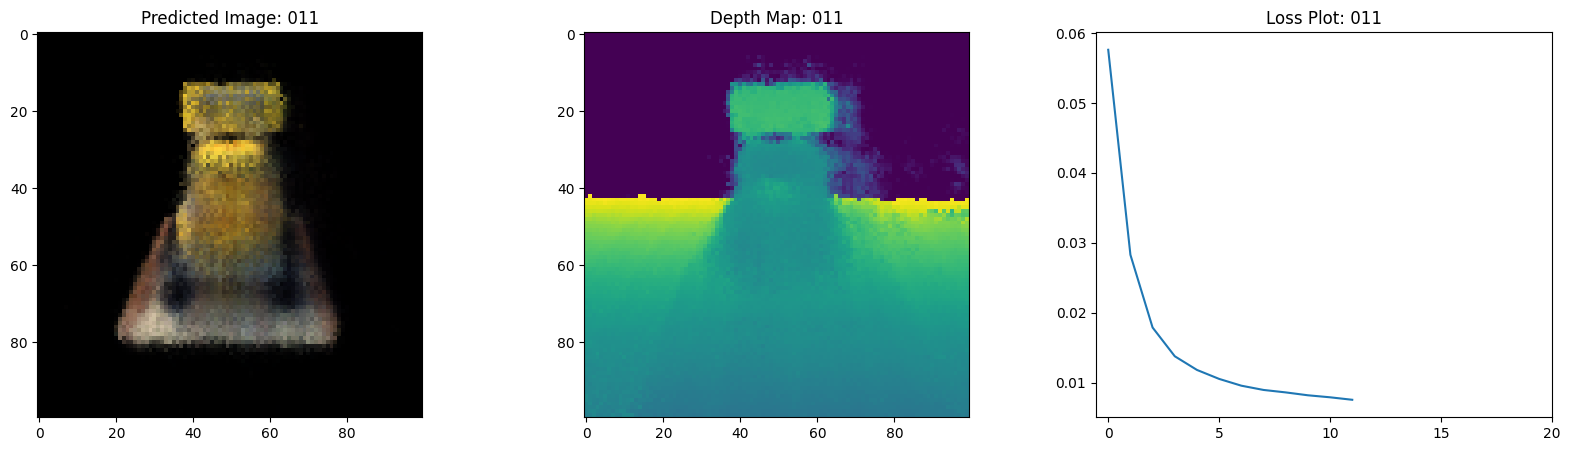

84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - loss: 0.0077 - psnr: 21.3157 - val_loss: 0.0078 - val_psnr: 21.2433
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/stepep - loss: 0.0075 - psnr: 21.421


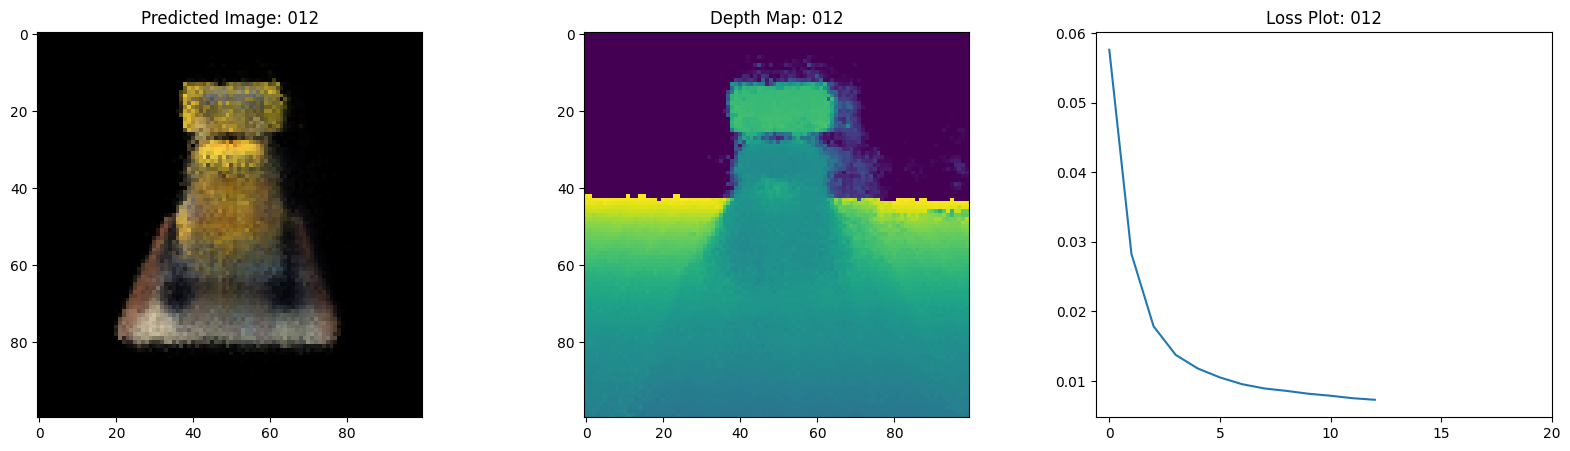

84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - loss: 0.0075 - psnr: 21.4224 - val_loss: 0.0076 - val_psnr: 21.3457
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/stepep - loss: 0.0072 - psnr: 21.584


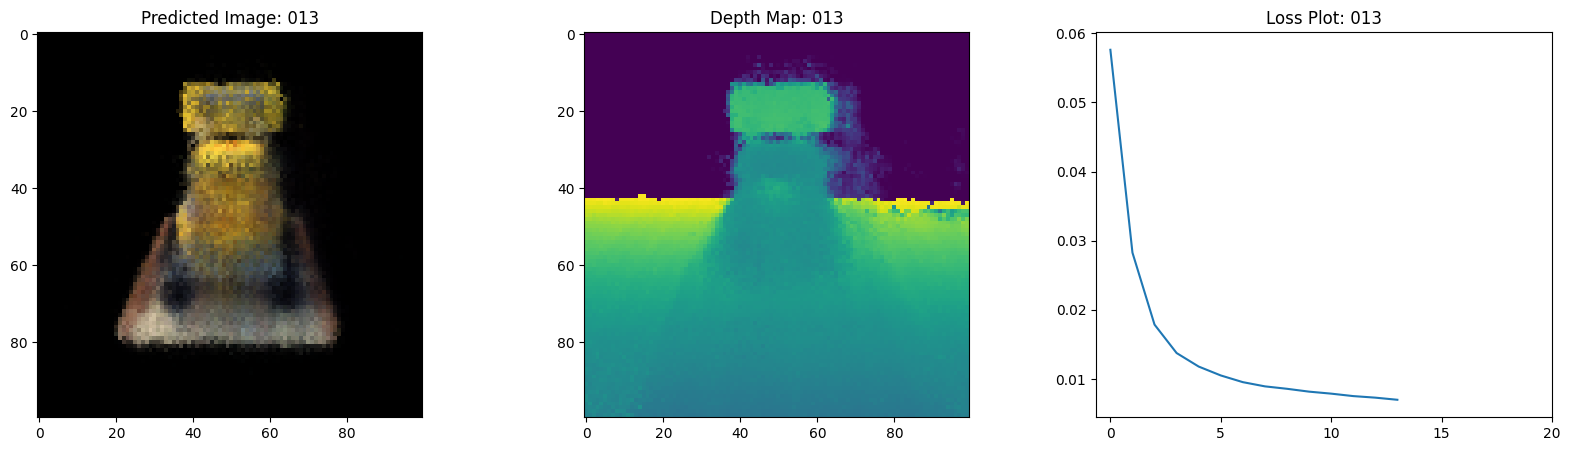

84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - loss: 0.0072 - psnr: 21.5859 - val_loss: 0.0075 - val_psnr: 21.4316
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/stepep - loss: 0.0071 - psnr: 21.697


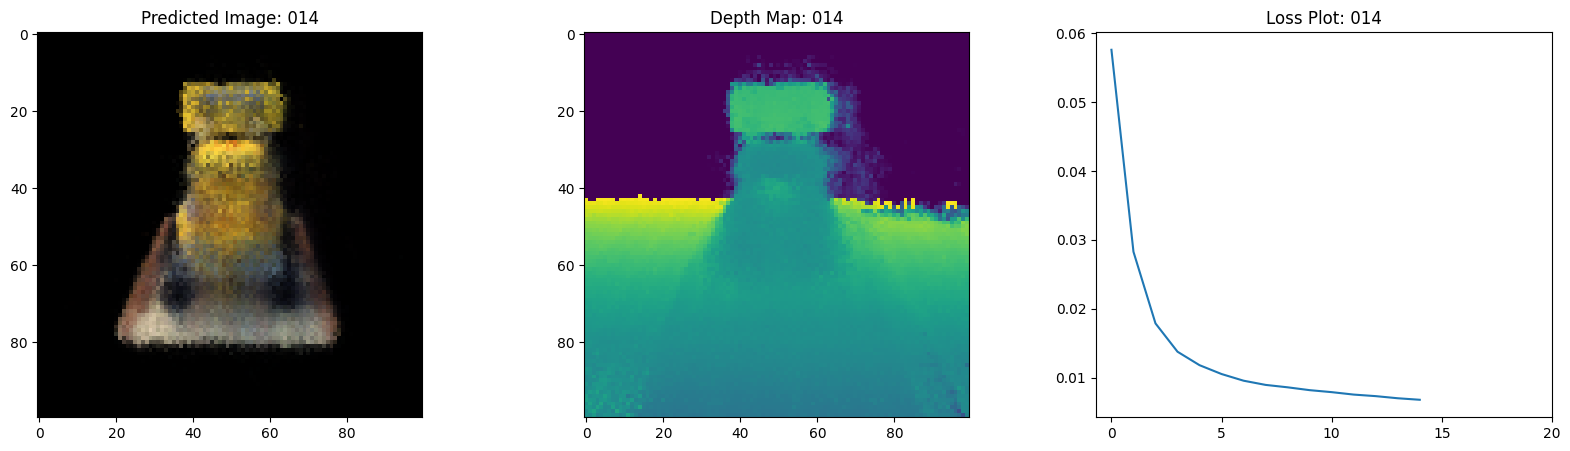

84/84 ━━━━━━━━━━━━━━━━━━━━ 22s 249ms/step - loss: 0.0071 - psnr: 21.6990 - val_loss: 0.0074 - val_psnr: 21.4441
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/steptep - loss: 0.0070 - psnr: 21.771


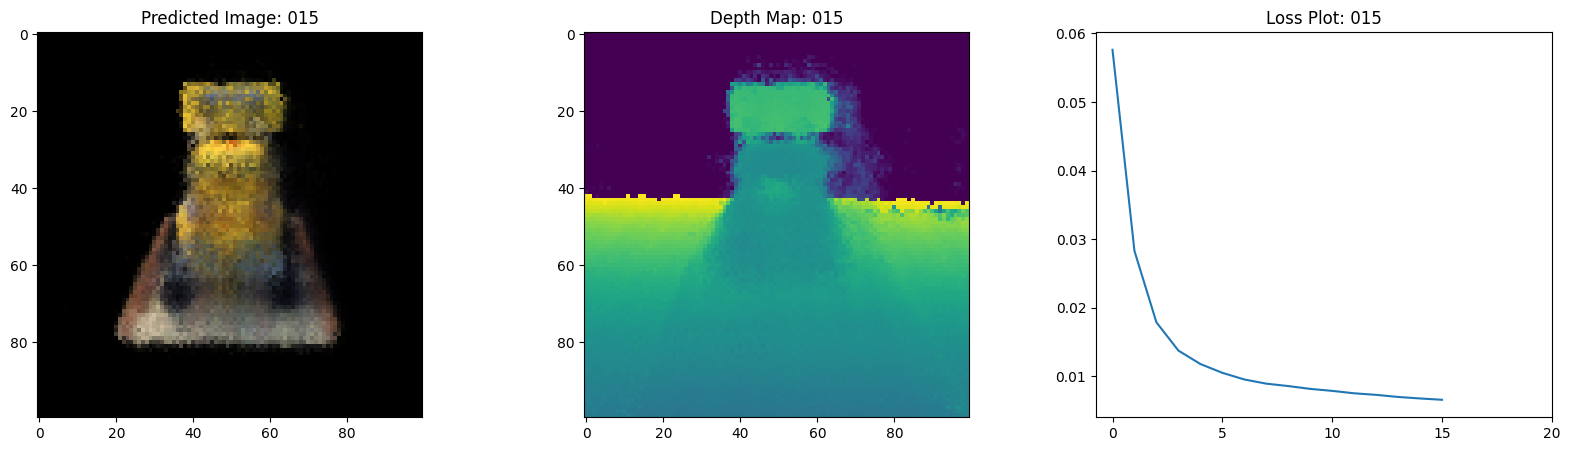

84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - loss: 0.0070 - psnr: 21.7740 - val_loss: 0.0073 - val_psnr: 21.5265
Epoch 17/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/stepep - loss: 0.0068 - psnr: 21.847


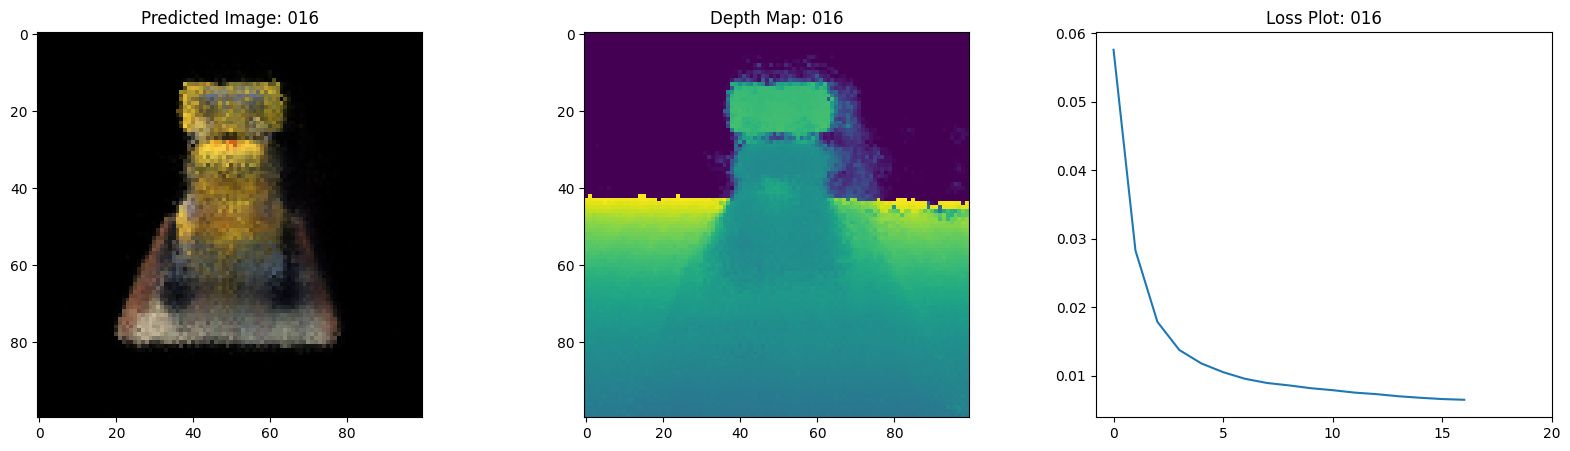

84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - loss: 0.0068 - psnr: 21.8497 - val_loss: 0.0072 - val_psnr: 21.5510
Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/steptep - loss: 0.0067 - psnr: 21.938


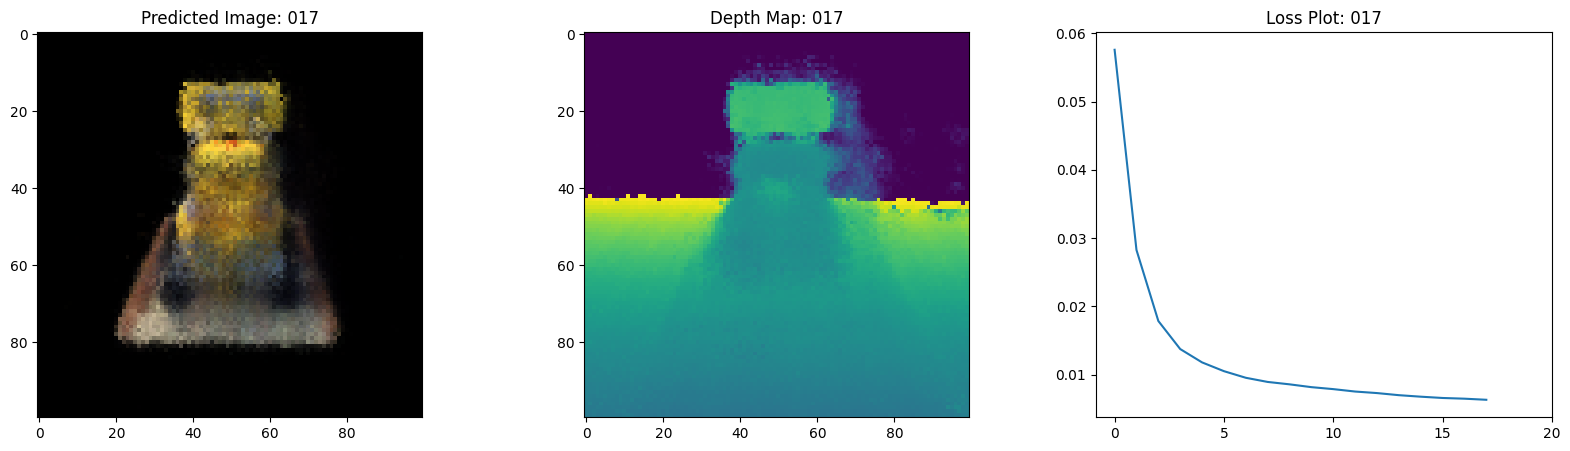

84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - loss: 0.0067 - psnr: 21.9413 - val_loss: 0.0073 - val_psnr: 21.5263
Epoch 19/20


2025-03-10 23:12:47.887800: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 128120000 bytes after encountering the first element of size 128120000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/stepep - loss: 0.0066 - psnr: 22.004


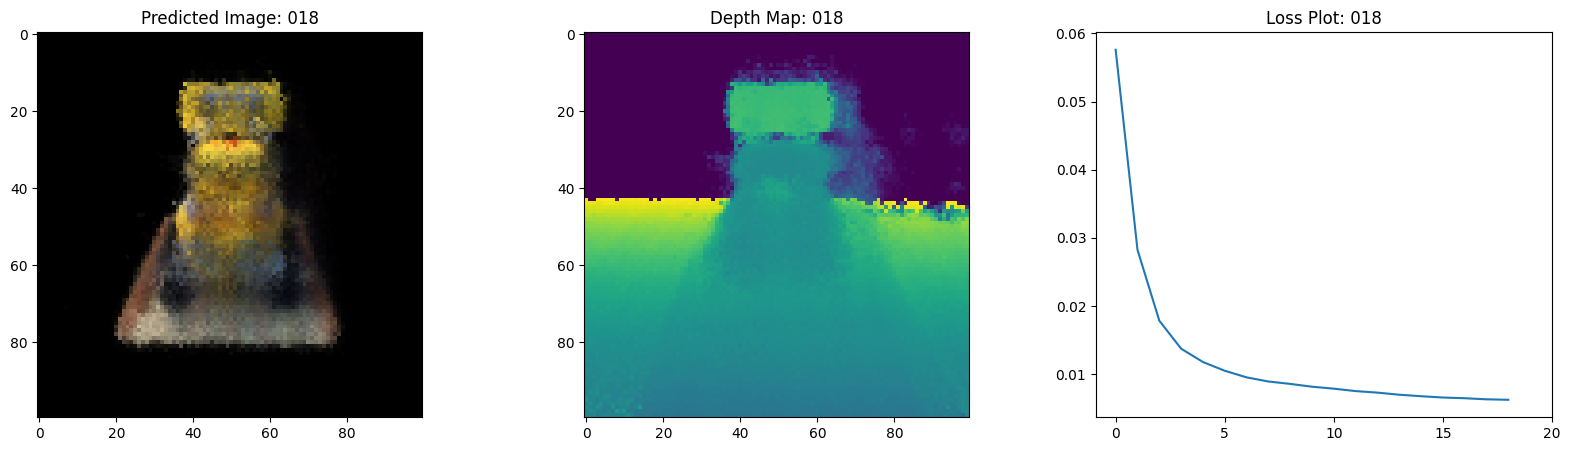

84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - loss: 0.0066 - psnr: 22.0068 - val_loss: 0.0073 - val_psnr: 21.5015
Epoch 20/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/stepep - loss: 0.0065 - psnr: 22.038


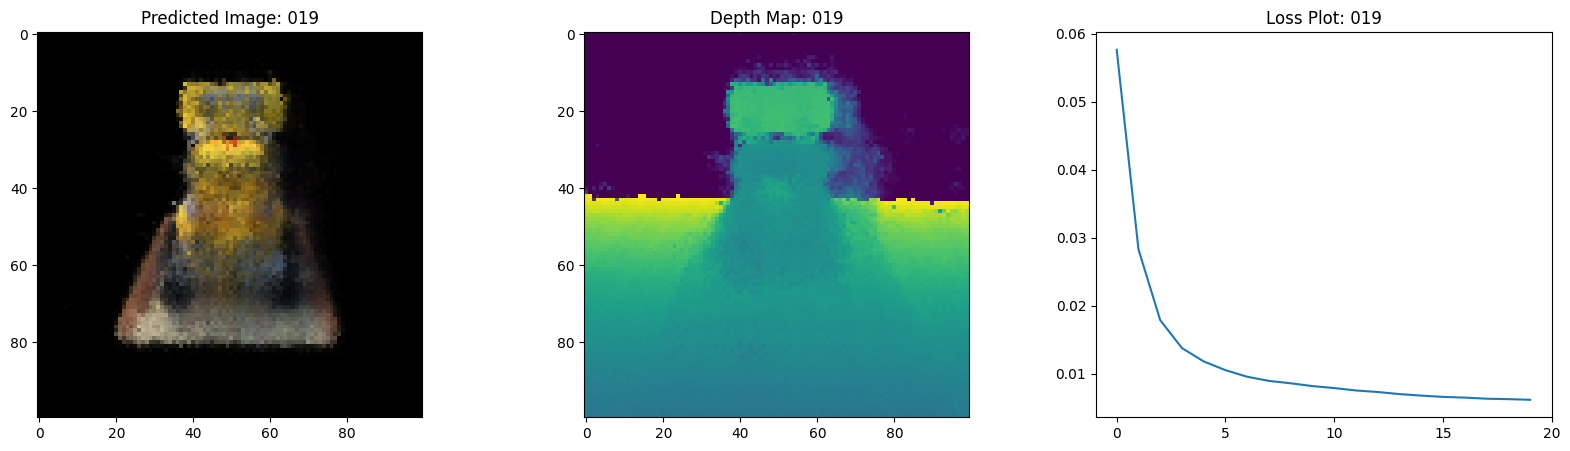

84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 242ms/step - loss: 0.0065 - psnr: 22.0414 - val_loss: 0.0073 - val_psnr: 21.5189


100%|██████████| 100/100 [00:01<00:00, 61.73it/s]


In [ ]:
class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss") # tracks mean squared error
        self.psnr_metric = keras.metrics.Mean(name="psnr") # Computes the Peak Signal-to-Noise Ratio (PSNR), which measures image quality.

    def train_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs # Extracts images and ray information.
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:  # automatic differentiation
            # Get the predictions from the model.
            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )  #generate an image from rays.
            loss = self.loss_fn(images, rgb)

        # Get the trainable variables.
        trainable_variables = self.nerf_model.trainable_variables # retrieves all parameters of the NeRF model that should be updated during training.


        # Get the gradeints of the trainiable variables with respect to the loss.
        gradients = tape.gradient(loss, trainable_variables)

        # Apply the grads and optimize the model.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        # Get the predictions from the model.
        rgb, _ = render_rgb_depth(
            model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
        )
        loss = self.loss_fn(images, rgb)

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    @property # define a method that behaves like an attribute.
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]


test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

loss_list = []


class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_depth(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            t_vals=test_t_vals,
            rand=True,
            train=False,
        )

        # Plot the rgb, depth and the loss plot.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(keras.utils.array_to_img(test_recons_images[0]))
        ax[0].set_title(f"Predicted Image: {epoch:03d}")

        ax[1].imshow(keras.utils.array_to_img(depth_maps[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:03d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[2].set_title(f"Loss Plot: {epoch:03d}")

        fig.savefig(f"images/{epoch:03d}.png")
        plt.show()
        plt.close()


num_pos = H * W * NUM_SAMPLES # positional encoding
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)

model = NeRF(nerf_model)
model.compile(
    optimizer=keras.optimizers.Adam(), loss_fn=keras.losses.MeanSquaredError()
)

# Create a directory to save the images during training.
if not os.path.exists("images"):
    os.makedirs("images")

model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[TrainMonitor()],
)


def create_gif(path_to_images, name_gif):
    filenames = glob.glob(path_to_images)
    filenames = sorted(filenames)
    images = []
    for filename in tqdm(filenames):
        images.append(imageio.imread(filename))
    kargs = {"duration": 0.25}
    imageio.mimsave(name_gif, images, "GIF", **kargs)




In [9]:
create_gif("images/*.png", "training.gif")

100%|██████████| 20/20 [00:00<00:00, 45.39it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


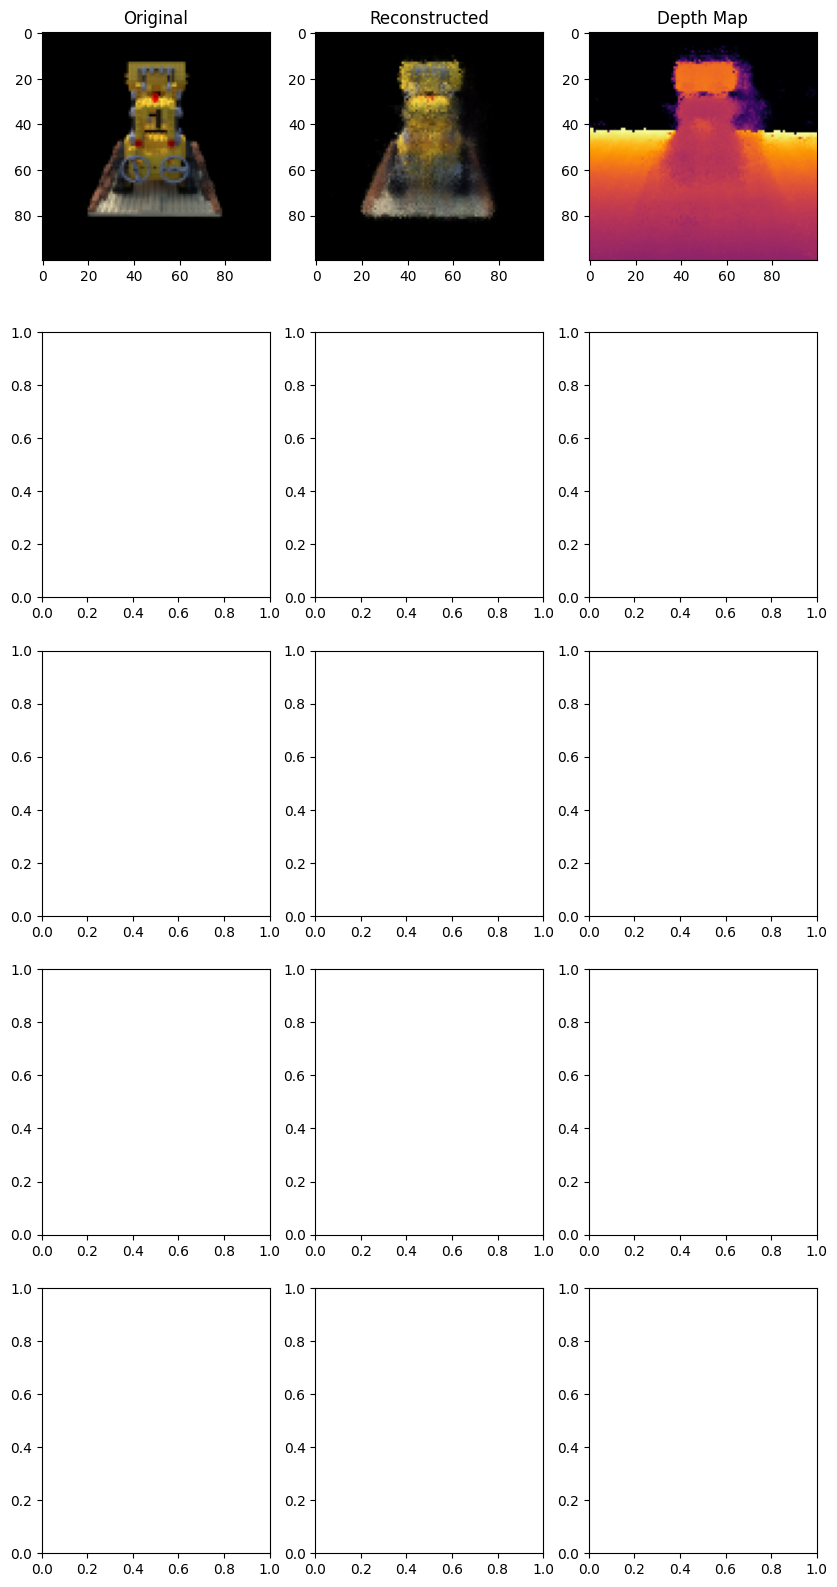

In [10]:
# Get the trained NeRF model and infer.
nerf_model = model.nerf_model
test_recons_images, depth_maps = render_rgb_depth(
    model=nerf_model,
    rays_flat=test_rays_flat,
    t_vals=test_t_vals,
    rand=True,
    train=False,
)

# Create subplots.
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for ax, ori_img, recons_img, depth_map in zip(
    axes, test_imgs, test_recons_images, depth_maps
):
    ax[0].imshow(keras.utils.array_to_img(ori_img))
    ax[0].set_title("Original")

    ax[1].imshow(keras.utils.array_to_img(recons_img))
    ax[1].set_title("Reconstructed")

    ax[2].imshow(keras.utils.array_to_img(depth_map[..., None]), cmap="inferno")
    ax[2].set_title("Depth Map")

In [13]:

def get_translation_t(t):
    """Get the translation matrix for movement in t."""
    matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_phi(phi):
    """Get the rotation matrix for movement in phi."""
    matrix = [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_theta(theta):
    """Get the rotation matrix for movement in theta."""
    matrix = [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def pose_spherical(theta, phi, t):
    """
    Get the camera to world matrix for the corresponding theta, phi
    and t.
    """
    c2w = get_translation_t(t)
    c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w


rgb_frames = []
batch_flat = []
batch_t = []

# Iterate over different theta value and generate scenes.
for index, theta in tqdm(enumerate(np.linspace(0.0, 360.0, 120, endpoint=False))):
    # Get the camera to world matrix.
    c2w = pose_spherical(theta, -30.0, 4.0)

    #
    ray_oris, ray_dirs = get_rays(H, W, focal, c2w)
    rays_flat, t_vals = render_flat_rays(
        ray_oris, ray_dirs, near=2.0, far=6.0, num_samples=NUM_SAMPLES, rand=False
    )

    if index % BATCH_SIZE == 0 and index > 0:
        batched_flat = tf.stack(batch_flat, axis=0)
        batch_flat = [rays_flat]

        batched_t = tf.stack(batch_t, axis=0)
        batch_t = [t_vals]

        rgb, _ = render_rgb_depth(
            nerf_model, batched_flat, batched_t, rand=False, train=False
        )

        temp_rgb = [np.clip(255 * img, 0.0, 255.0).astype(np.uint8) for img in rgb]

        rgb_frames = rgb_frames + temp_rgb
    else:
        batch_flat.append(rays_flat)
        batch_t.append(t_vals)

rgb_video = "rgb_video.mp4"
imageio.mimwrite(rgb_video, rgb_frames, fps=30, quality=7, macro_block_size=None)

0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


2it [00:00, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


4it [00:00,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


5it [00:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


6it [00:01,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


7it [00:01,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


8it [00:01,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


9it [00:01,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


10it [00:01,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


11it [00:02,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


12it [00:02,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


13it [00:02,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


14it [00:02,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


15it [00:02,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


16it [00:02,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


17it [00:03,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


18it [00:03,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


19it [00:03,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


20it [00:03,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


21it [00:03,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


22it [00:03,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


23it [00:04,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


24it [00:04,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


25it [00:04,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


26it [00:04,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


27it [00:04,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


28it [00:04,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


29it [00:05,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


30it [00:05,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


31it [00:05,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


32it [00:05,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


33it [00:05,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


34it [00:05,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


35it [00:06,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


36it [00:06,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


37it [00:06,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


38it [00:06,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


39it [00:06,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


40it [00:06,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


41it [00:07,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


42it [00:07,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


43it [00:07,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


44it [00:07,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


45it [00:07,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


46it [00:07,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


47it [00:08,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


48it [00:08,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


49it [00:08,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


50it [00:08,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


51it [00:08,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


52it [00:08,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


53it [00:09,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


54it [00:09,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


55it [00:09,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


56it [00:09,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


57it [00:09,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


58it [00:09,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


59it [00:10,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


60it [00:10,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


61it [00:10,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


62it [00:10,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


63it [00:10,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


64it [00:10,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


65it [00:11,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


66it [00:11,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


67it [00:11,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


68it [00:11,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


69it [00:11,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


70it [00:11,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


71it [00:12,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


72it [00:12,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


73it [00:12,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


74it [00:12,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


75it [00:12,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


76it [00:12,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


77it [00:13,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


78it [00:13,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


79it [00:13,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


80it [00:13,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


81it [00:13,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


82it [00:13,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


83it [00:13,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


84it [00:14,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


85it [00:14,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


86it [00:14,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


87it [00:14,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


88it [00:14,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


89it [00:14,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


90it [00:15,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


91it [00:15,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


92it [00:15,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


93it [00:15,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


94it [00:15,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


95it [00:15,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


96it [00:16,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


97it [00:16,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


98it [00:16,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


99it [00:16,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


100it [00:16,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


101it [00:16,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


102it [00:17,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


103it [00:17,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


104it [00:17,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


105it [00:17,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


106it [00:17,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


107it [00:17,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


108it [00:18,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


109it [00:18,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


110it [00:18,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


111it [00:18,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


112it [00:18,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


113it [00:18,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


114it [00:19,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


115it [00:19,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


116it [00:19,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


117it [00:19,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


118it [00:19,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


119it [00:19,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


120it [00:20,  5.95it/s]
